# Recitation 7: PyMC3 and categorical variables

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](r7_pymc3.ipynb).*


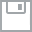
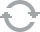
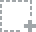
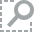
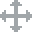
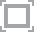
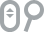
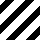
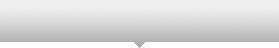
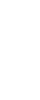
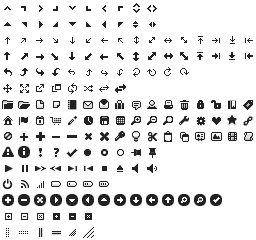
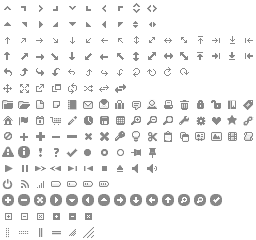
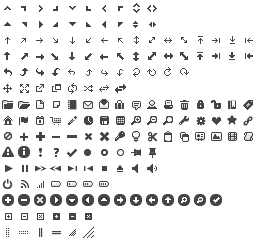
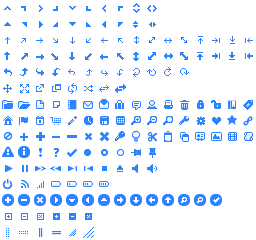
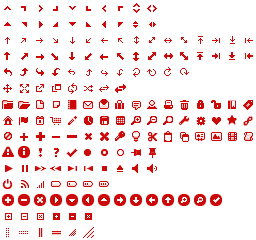
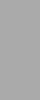
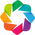
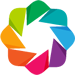

In [1]:
import itertools
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.special

# Packages we use with PyMC3
import pymc3
import theano

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this tutorial, we will learn how to use [PyMC3](https://pymc-devs.github.io/pymc3/), a major Python package for MCMC, to do some of the calculations we've done in class.  We will also use it to analyze systems with **categorical variables**, which can only take discrete values.

## Example: Heritability and finch beaks
Peter and Rosemary Grant have been working on the Galápagos island of Daphne for over forty years.  During this time, they have collected lots and lots of data about physiological features of finches.  Last year, they published a book with a summary of some of their major results (Grant P. R., Grant B. R., *Data from: 40 years of evolution. Darwin's finches on Daphne Major Island*, Princeton University Press, 2014). They made their data from the book publicly available via the [Dryad Digital Repository](http://dx.doi.org/10.5061/dryad.g6g3h).

We will investigate their data on the heritability of beak depth (the distance, top to bottom, of a closed beak) in the ground finch *Geospiza fortis*.  The data set consists of the maternal beak depth, the paternal beak depth, and the mean beak depth of their offspring.  You can download the data set, which I got from Dryad and tidied up into a CSV file, [here](../data/grant_and_grant.csv).

The **narrow sense heritability**, denoted $h^2$, of a trait is defined as the ratio of the additive genetic variance in offspring to the total phenotypic variance in the parent.  The additive genetic variance of a population describes the variability in a trait resulting from the sum of all effects of the alleles.  In other words, $h^2$ is the ratio of the parent-offspring covariance in the trait value to the variance in the parents.

\begin{align}
h^2 = \frac{\sigma_{po}^2}{\sigma_p^2},
\end{align}

where the subscripts $o$ and $p$ indicate offspring and parents, respectively.

### Computing $h^2$
In practice, $h^2$ is computed by plotting the average beak depth of the offspring against the average beak depth of the two parents, and then preforming a linear regression, with $h^2$ being given by the slope.  To show that the slope does indeed give $h^2$, we are actually seeking to prove something more general: the slope of a linear regression between two variables, say $x$ and $y$, is the ratio of the covariance to the variance in the $x$-variable.  To prove, this we set up the linear regression, as in class, by writing the posterior probability distribution.  Beginning with Bayes's theorem, 

\begin{align}
P(m, b, \sigma \mid D) = \frac{P(D\mid m, b, \sigma)\,P(m, b, \sigma)}{P(D)}.
\end{align}

We assume the data follow $y = mx + b$ and that the errors are Gaussian distributed, all with the same error bar, $\sigma$.  This gives a likelihood of

\begin{align}
P(D\mid m, b, \sigma) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left\{-\frac{(y_i - m x_i - b)^2}{2\sigma^2}\right\}.
\end{align}

We assume a Jeffreys prior for $\sigma$, and an uninformative prior for the linear regression parameters $m$ and $b$ as discussed in class.

\begin{align}
P(m, b, \sigma) \propto \frac{1}{\sigma(1 + m^2)^{\frac{3}{2}}}.
\end{align}

The log posterior is then

\begin{align}
\ln P(m, b, \sigma \mid D) \propto -(n + 1) \ln \sigma - \frac{3}{2}\,\ln\left(1 + m^2\right) - \frac{1}{2\sigma^2}\sum_{i\in D} \left(y_i - m x_i - b\right)^2,
\end{align}

where $n = |D|$.  To find the most probable slope and intercept, we differentiate the log posterior and find where the gradient is zero.

\begin{align}
\frac{\partial}{\partial m}\,\ln P(m, b, \sigma \mid D) 
&= -\frac{3m}{1+m^2} + 2\sum_{i\in D} \left( y_i - m x_i - b\right)x_i = 0, \\[1em]
\frac{\partial}{\partial b}\,\ln P(m, b, \sigma \mid D)
&= 2\sum_{i\in D} \left( y_i - m x_i - b\right) = 0.
\end{align}

We can multiply the each equation by $1/2n$ to get

\begin{align}
-\frac{3m}{2n\left(1+m^2\right)} + \langle xy \rangle - m\langle x^2 \rangle - b\langle x \rangle &= 0,\\[1em]
\frac{1}{n}\sum_{i\in D} \left( y_i - m x_i - b\right) = \langle y\rangle - m\langle x\rangle - b &= 0.
\end{align}

We solve the bottom equation for $b$

\begin{align}
b = \langle y \rangle - m \langle x \rangle,
\end{align}

which we then insert into the top equation, giving

\begin{align}
-\frac{3m}{2n\left(1+m^2\right)} + \langle xy \rangle - m\langle x^2 \rangle - \left(\langle y \rangle - m \langle x\right\rangle)\langle x \rangle &= 0.
\end{align}

This can be rearranged to give

\begin{align}
m = \frac{\langle xy \rangle - \langle x \rangle\langle y\rangle}{\left\langle x^2 - \langle x \rangle^2\right\rangle} -\frac{3m}{2n\left(1+m^2\right)\left\langle x^2 - \langle x\rangle^2\right\rangle}.
\end{align}

This is a cubic equation in $m$, for which an analytical solution exists, but is messy.  Instead, we make the approximation that if $n$ is large and the covariance is not too small, the second term is negligible, which is equivalent to assuming the prior for $m$ is uniform, giving

\begin{align}
m \approx \frac{\langle xy\rangle - \langle x\rangle \langle y \rangle}{\left\langle x^2 - \langle x \rangle^2\right\rangle}.
\end{align}

We recognize the numerator as the sample covariance between $x$ and $y$ and the denominator as the sample variance of $x$.  Thus, we have proven what we set out to prove.

*Note*: in this analysis, we are neglecting confounding issues and just assuming the environment is unchanging and that the mean trait values we are using for the parents and the offspring is indicative of the differences.

### Performing a linear regression with PyMC3
We will now use the finch beak data to perform a linear regression and compute the heritability, $h^2$.  We start by loading in the data set and adjusting column headings for convenience.

In [2]:
# Read data
df = pd.read_csv('../data/grant_and_grant/grant_and_grant_2014.csv')

# Rename columns
df.columns = ('offspring_bd', 'male_bd', 'female_bd')

We will need the mean parental beak depth for our regression, so we create a new column in the `DataFrame` that has that.

In [3]:
# Make a new column with the mean of the male and female parent columns
df['parent_bd'] = (df.male_bd + df.female_bd) / 2

We'll first plot the data to see what we are dealing with.  We make the plot interactive with Bokeh to enable zooming.

In [4]:
# Make plot of offspring beak depth vs parental beak depth
plt.plot(df.parent_bd, df.offspring_bd, 'o')
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')

# Make it interactive with Bokeh
bokeh.plotting.show(bokeh.mpl.to_bokeh())

By eye, we see correlation between the parents and the offspring.  To find the most probable parameter values for the slope and intercept, we can be cute and use the result derived above and just compute the sample covariance matrix.

In [5]:
# Compute covariance matrix
cov = df.cov()

# Compute the regression line
h_2 = cov['parent_bd']['offspring_bd'] / cov['parent_bd']['parent_bd']
intercept = df.offspring_bd.mean() - h_2 * df.parent_bd.mean()

# Print the results to the screen
print("""
heritability = {0:.2f}
   intercept = {1:.2f} mm
""".format(h_2, intercept))


heritability = 0.72
   intercept = 2.45 mm



### MCMC using PyMC3
PyMC3 is flexible in that you can rapidly define your models with built-in functions, especially if you are using standard probability distributions.  It is fast because it uses [Theano](http://www.deeplearning.net/software/theano/) to do the sampling using compiled code.  The use of Theano does make PyMC3 a little bit more difficult to use than `emcee`, since you are restricted to Theano's built-in operators (though there are some ways around that).

Anyhow, the code below does MCMC sampling of the posterior for the linear regression using PyMC3.  You may get some errors and warnings from Theano, but these should be inconsequential.

In [6]:
# Make custom Jeffreys prior, returns log prior
def jeffreys(value):
    return -theano.tensor.log(value)

# Instantiate model
model = pymc3.Model()
with model:
    # Priors for unknown model parameters
    sigma = pymc3.DensityDist('sigma', jeffreys, testval=1)
    slope = pymc3.Uniform('slope', lower=-1, upper=1, testval=0.5)
    intercept = pymc3.Uniform('intercept', lower=-10, upper=10, testval=0)

    # Expected value of outcome
    mu = slope * df.parent_bd + intercept

    # Likelihood (sampling distribution) of observations
    y_obs = pymc3.Normal('y_obs', mu=mu, sd=sigma, observed=df.offspring_bd)

Now that we have the model specified, we can do steps.  We'll start with a standard Metropolis sampler, and take 10K burn-in steps and 100K steps.

In [7]:
with model:    
    # Specify stepper
    step = pymc3.Metropolis()

    # draw 10000 posterior samples for burn-in
    trace = pymc3.sample(10000, step)

    # Start next run of 100000 samples at the last sampled position.
    step = pymc3.Metropolis()
    trace = pymc3.sample(100000, step, start=trace[-1])

 [-----------------100%-----------------] 100000 of 100000 complete in 21.2 sec

We can use the `pymc3.summary` function to print out the results.

In [8]:
# Print summary of MCMC results
pymc3.summary(trace, ['slope', 'intercept', 'sigma'])


slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.725            0.030            0.002            [0.665, 0.782]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.664          0.706          0.725          0.745          0.781


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.429            0.288            0.023            [1.888, 3.001]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.895          2.242          2.424          2.610          3.011


sigma:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

This is convenient, and we see that we got close to the results we would expect from our direct calculation, $h^2 = 0.72$.

We can look at the traces and the marginalized posteriors (with KDE) using `pymc3.traceplot()`.

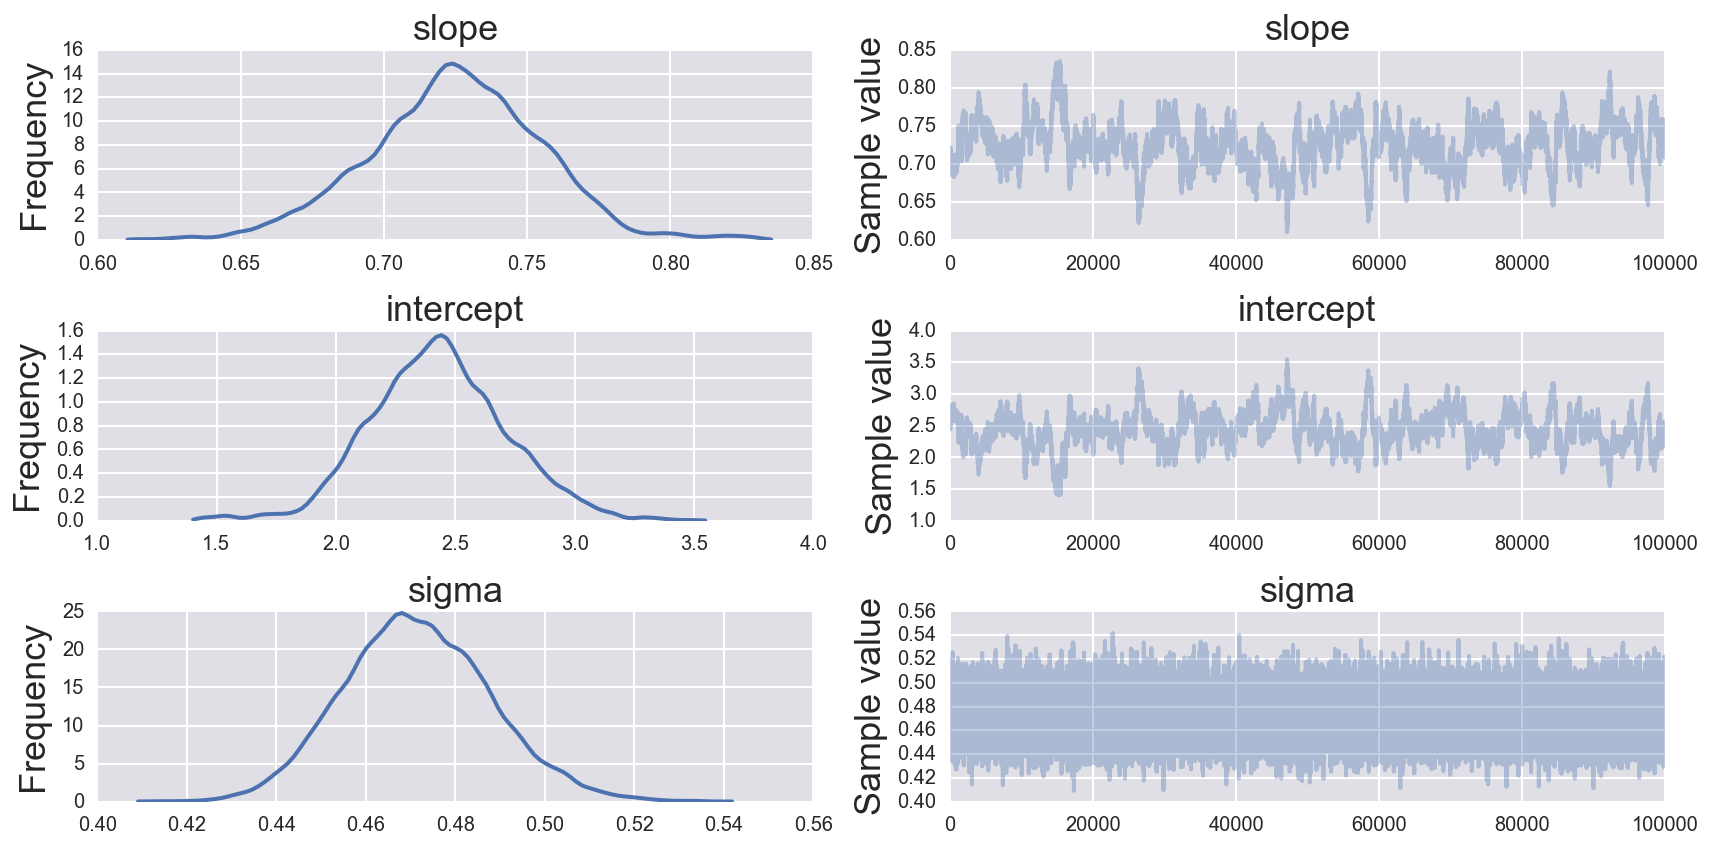

In [9]:
pymc3.traceplot(trace, ['slope', 'intercept', 'sigma']);

In looking at the MCMC samples to the right for the `slope` and `intercept`, we see a sterotypical "snake" pattern, which means that we probably haven't sampled enough.  Typically, you want plots that look like the sampling of `sigma`.

Instead of taking more steps, we will use a more efficient sampler, a No-U-Turn Sampler, or NUTS.  This will take longer for Theano to compile, but once it starts sampling, it is far more efficient than Metropolis.

In [10]:
with model:    
    # Specify stepper (use fast NUTS stepper)
    step = pymc3.NUTS()

    # draw 1000 posterior samples for burn-in
    trace = pymc3.sample(1000, step)

    # Start next run of 10000 samples at the last sampled position.
    step = pymc3.NUTS(scaling=trace[-1])
    trace = pymc3.sample(10000, step, start=trace[-1])

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 196, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 82, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5499, in apply
    new_outputs = self.optimizer(node)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5434, in local_fuse
    n = OP(C)(*inputs).owner
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/elemwise.py", line 496, in __init__
   

 [-----------------100%-----------------] 10000 of 10000 complete in 26.2 sec

Let's look at the trace plot for this sampler.

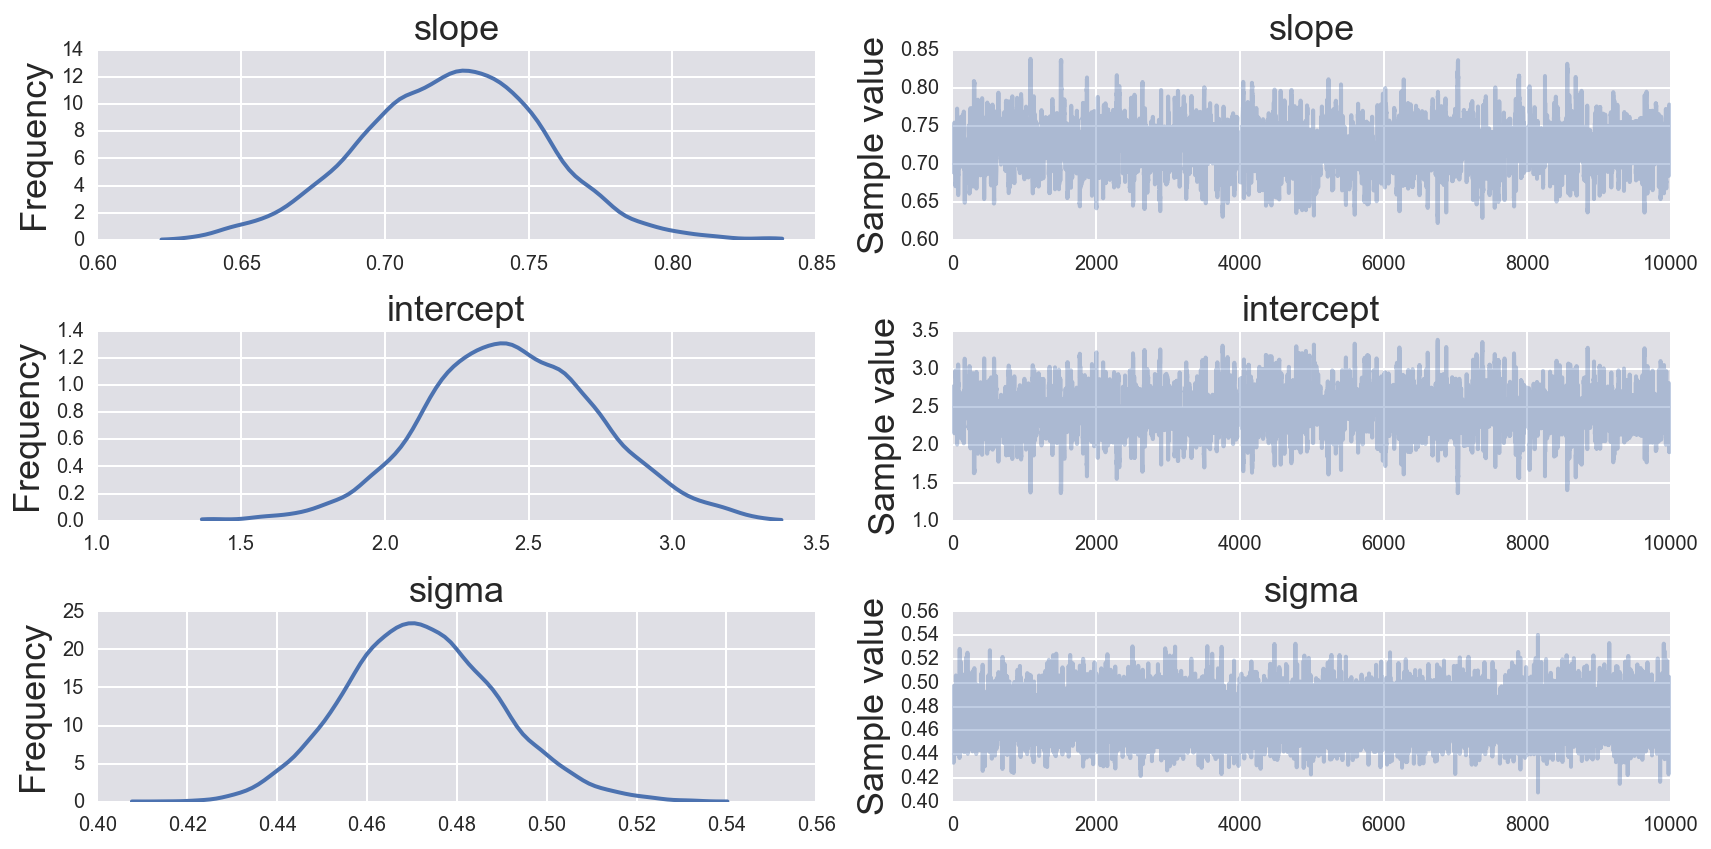

In [11]:
pymc3.traceplot(trace, ['slope', 'intercept', 'sigma']);

The sampling is much more efficient, and we get better posteriors with far fewer steps.

## Nonlinear regression
In fact, doing standard regressions with PyMC3 is pretty straightforward.  You just have to code up the deterministic model, and everything else is pretty much boilerplate.  Let's do a regression with the Good, et al. data.

In [12]:
# Load data into DataFrame
df = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', comment='#')
d = df['Droplet Diameter (um)']
ell = df['Spindle Length (um)']

# Make custom Jeffreys prior, returns log prior
def jeffreys(value):
    return -theano.tensor.log(value)

# Instantiate model
model = pymc3.Model()
with model:
    # Priors for unknown model parameters
    sigma = pymc3.DensityDist('sigma', jeffreys, testval=1)
    gamma = pymc3.Uniform('gamma', lower=0, upper=1, testval=0.5)
    theta = pymc3.Uniform('theta', lower=0, upper=1000, testval=80)
    
    # Expected value of outcome
    mu = gamma * d / (1 + (gamma * d / theta)**3)**(1.0/3.0)

    # Likelihood (sampling distribution) of observations
    y_obs = pymc3.Normal('y_obs', mu=mu, sd=sigma, observed=ell)

With the model set up, we'll again use NUTS.

In [13]:
with model:    
    # Specify stepper (use fast NUTS stepper)
    step = pymc3.NUTS()

    # draw 1000 posterior samples for burn-in
    trace = pymc3.sample(1000, step)

    # Start next run of 5000 samples at the last sampled position.
    step = pymc3.NUTS(scaling=trace[-1])
    trace = pymc3.sample(5000, step, start=trace[-1])

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 196, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 82, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5499, in apply
    new_outputs = self.optimizer(node)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5434, in local_fuse
    n = OP(C)(*inputs).owner
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/elemwise.py", line 496, in __init__
   

 [-----------------100%-----------------] 5000 of 5000 complete in 7.6 sec

And we'll look at the results.

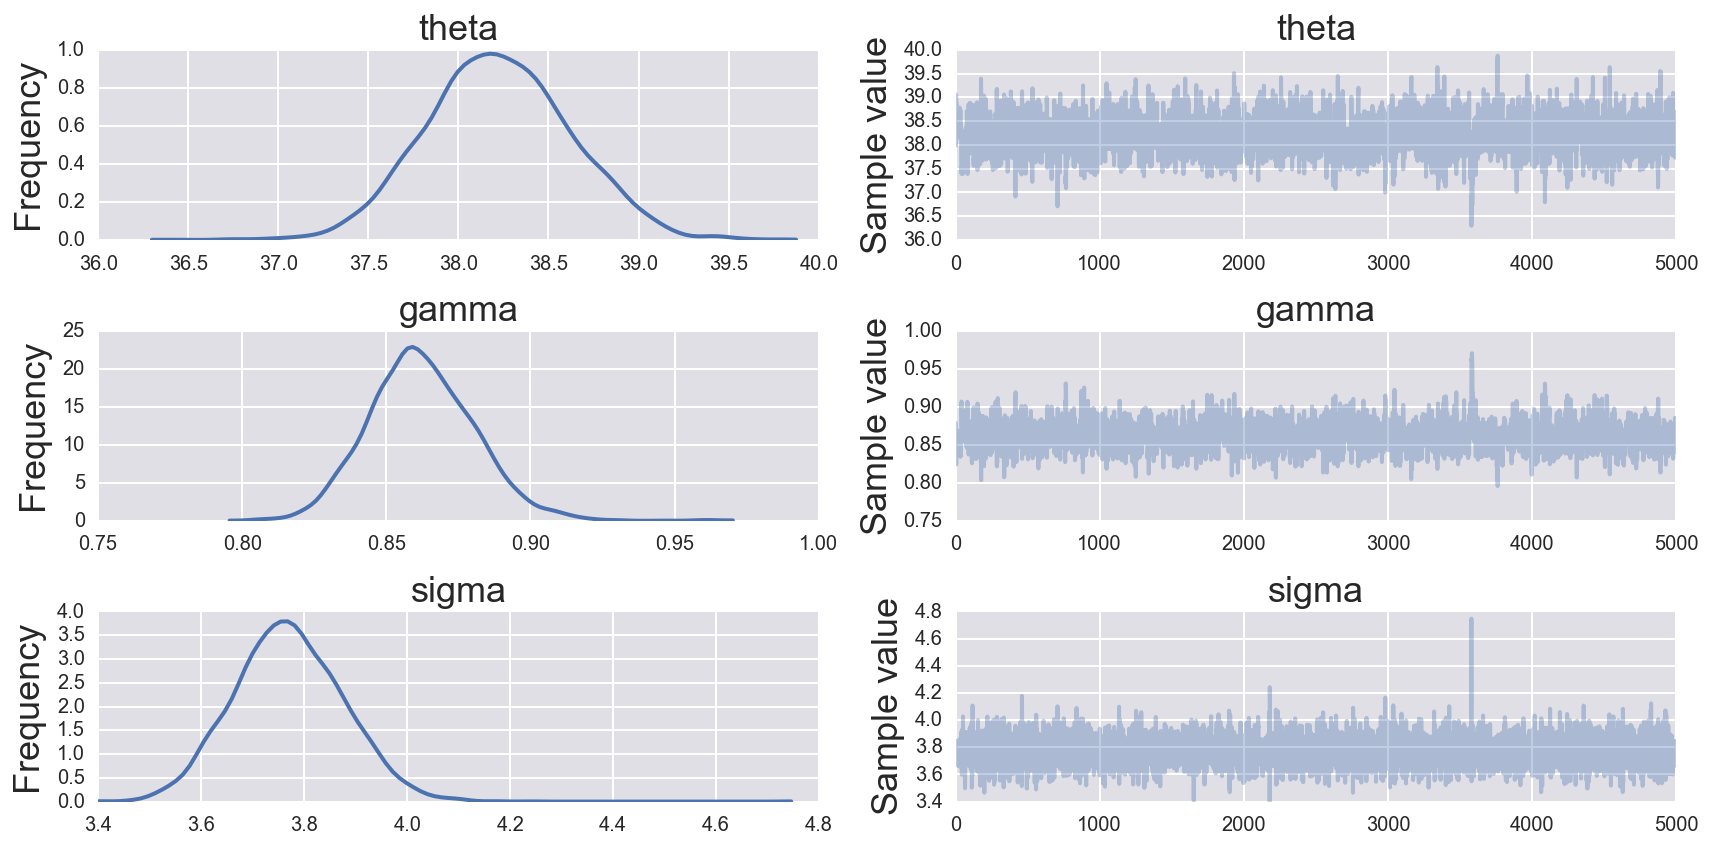

In [14]:
pymc3.traceplot(trace, ['theta', 'gamma', 'sigma']);

## MLE of the Singer, et al. data
We will now do a maximum likelihood estimate for the Singer, et al. data using PyMC3.  We will only do the single negative binomial estimate because coding up the double negative binomial estimate requires some sophisticated Theano code.

The built-in negative binomial in PyMC3 is parametrized as

\begin{align}
P(x \mid \mu, \alpha) = \frac{\Gamma(x+\alpha)}{x! \Gamma(\alpha)} \left(\frac{\alpha}{\mu+\alpha}\right)^\alpha \left(\frac{\mu}{\mu+\alpha}\right)^x,
\end{align}

as opposed to the definition we have been using of

\begin{align}
P(n \mid r, p) = \frac{\Gamma(n + r )}{n!\Gamma(r)}\,p^r(1-p)^n.
\end{align}

We see that $x=n$, $\alpha=r$, and $\mu = r(1-p)/p$.  With this defintion, $\mu$ can be any positive number, as can $\alpha$.

In [15]:
# Load DataFrame
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv',
                 comment='#')

# Instantiate model
basic_model = pymc3.Model()
with basic_model:
    # Priors for unknown model parameters
    p = pymc3.Uniform('p', lower=0, upper=1, testval=0.5)
    r = pymc3.Uniform('r', lower=0, upper=10, testval=1)
    
    # Convert to mu
    mu = r * (1 - p) / p

    # Likelihood (sampling distribution) of observations
    y_obs = pymc3.NegativeBinomial('n', mu=mu, alpha=r, observed=df['Rest'])
    
    # Specify stepper (use fast NUTS stepper)
    step = pymc3.NUTS()

    # draw 1000 posterior samples for burn-in
    trace = pymc3.sample(1000, step)

    # Start next run of 5000 samples at the last sampled position.
    step = pymc3.NUTS(scaling=trace[-1])
    trace = pymc3.sample(5000, step, start=trace[-1])

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR:theano.gof.opt:SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x113ed2470>
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 196, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/gof/opt.py", line 82, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5499, in apply
    new_outputs = self.optimizer(node)
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/opt.py", line 5434, in local_fuse
    n = OP(C)(*inputs).owner
  File "/Users/Justin/anaconda/lib/python3.4/site-packages/theano/tensor/elemwise.py", line 496, in __init__
   

 [-----------------100%-----------------] 5000 of 5000 complete in 12.8 sec

We can peak at the results.

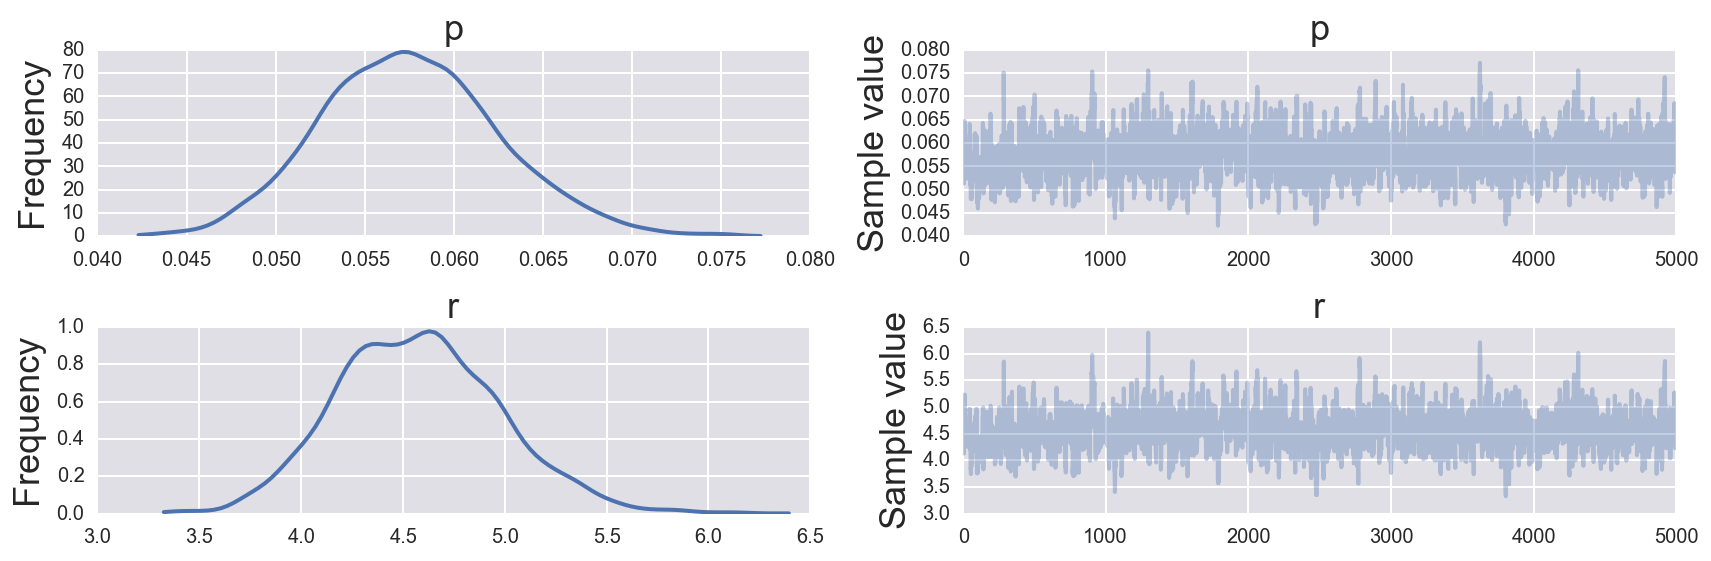

In [20]:
pymc3.traceplot(trace, ['p', 'r']);

## Hierarchical model from lecture
We can also do the hierarchical model from lecture 8.

In [21]:
# Fabricate data
r = np.array([9, 16, 14, 5, 110])
n = np.array([35, 40, 40, 34, 660])

# Special Jeffreys distribution for kappa
def kappa_jeffreys(value):
    return -theano.tensor.log(value - 2)

model = pymc3.Model()
with model:
    # Priors on q and kappa hyper parameters
    q = pymc3.Uniform('q', lower=0, upper=1, testval=0.5)
    kappa = pymc3.DensityDist('kappa', kappa_jeffreys, testval=4)

    # alpha and beta
    alpha = q * (kappa - 2) + 1
    beta = (1 - q) * (kappa - 2) + 1
    
    # Parameters
    p = pymc3.Beta('p', alpha=alpha, beta=beta, shape=len(r))
    
    # Number of reversals
    r_obs = pymc3.Binomial('r_obs', n=n, p=p, observed=r)

We'll use Metropolis because the boundaries on $\kappa$ disallow use of NUTS because of the discontinuity.

In [34]:
with model:
    # Specify stepper
    step = pymc3.Metropolis()

    # draw 10000 posterior samples for burn-in
    trace = pymc3.sample(10000, step)

    # Start next run of 50000 samples at the last sampled position.
    step = pymc3.Metropolis()
    trace = pymc3.sample(50000, step, start=trace[-1])

 [-----------------100%-----------------] 50000 of 50000 complete in 15.7 sec

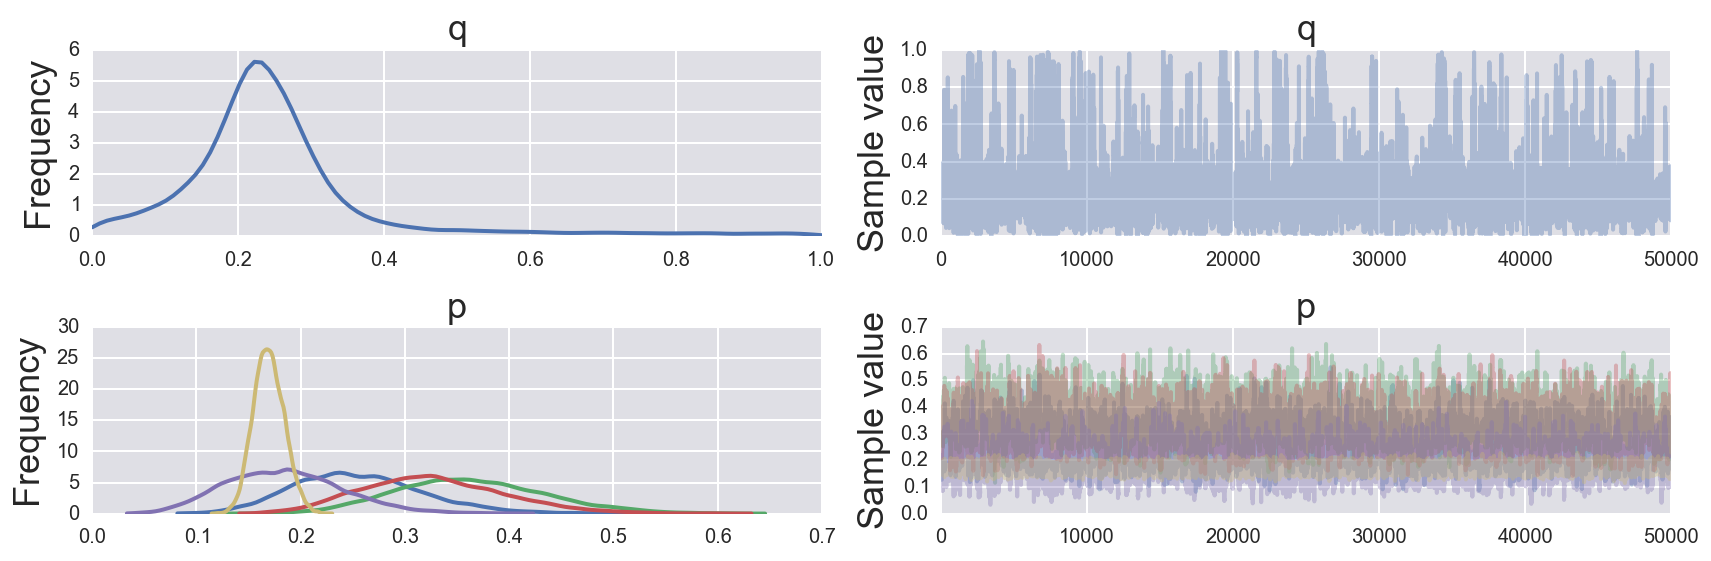

In [35]:
pymc3.traceplot(trace, ['q', 'p']);

## Coal mining disasters (from PyMC3 tutorial)
We'll look at coal mining disasters from the PyMC3 tutorial.

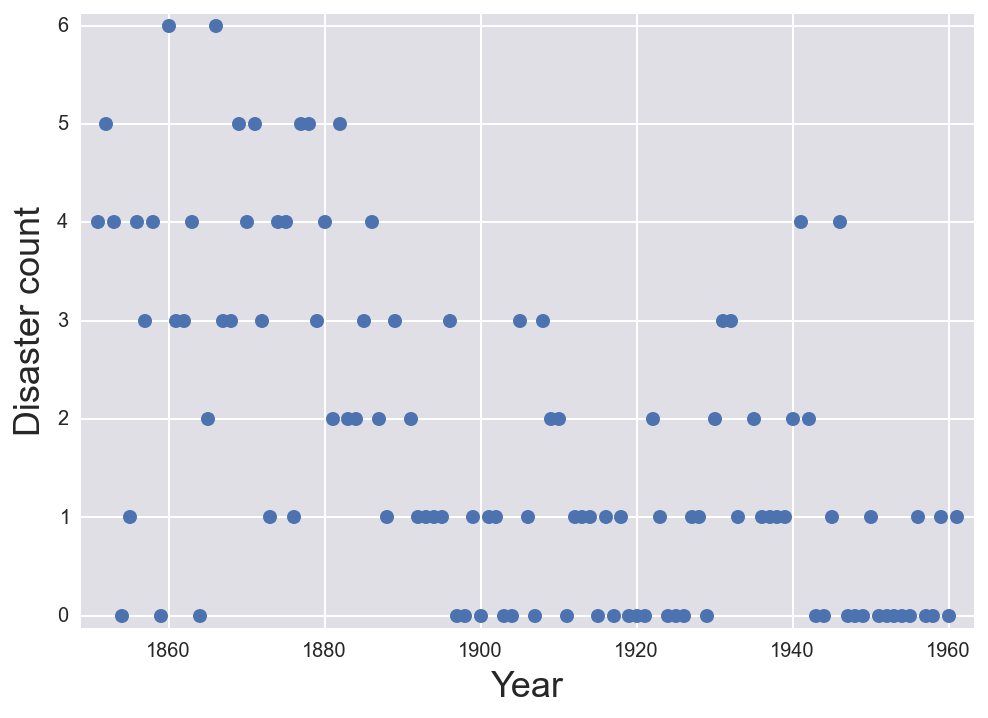

In [24]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o')
plt.ylabel("Disaster count")
plt.xlabel("Year")
plt.margins(0.02)

In [25]:
with pymc3.Model() as disaster_model:

    switchpoint = pymc3.DiscreteUniform('switchpoint', 
                                        lower=year.min(), upper=year.max(), 
                                        testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pymc3.Exponential('early_rate', 1)
    late_rate = pymc3.Exponential('late_rate', 1)

    # The disaster rate (pymc3.switch is like an if statement)
    rate = pymc3.switch(switchpoint >= year, early_rate, late_rate)

    # Disasters
    disasters = pymc3.Poisson('disasters', rate, observed=disaster_data)
       
    # Use NUTS for continuous
    step1 = pymc3.NUTS([early_rate, late_rate])

    # Use Metropolis for switchpoint, and missing values
    step2 = pymc3.Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = pymc3.sample(10000, step=[step1, step2])

 [-----------------100%-----------------] 10000 of 10000 complete in 8.9 sec

We can look at the traceplot to see when the switch was.

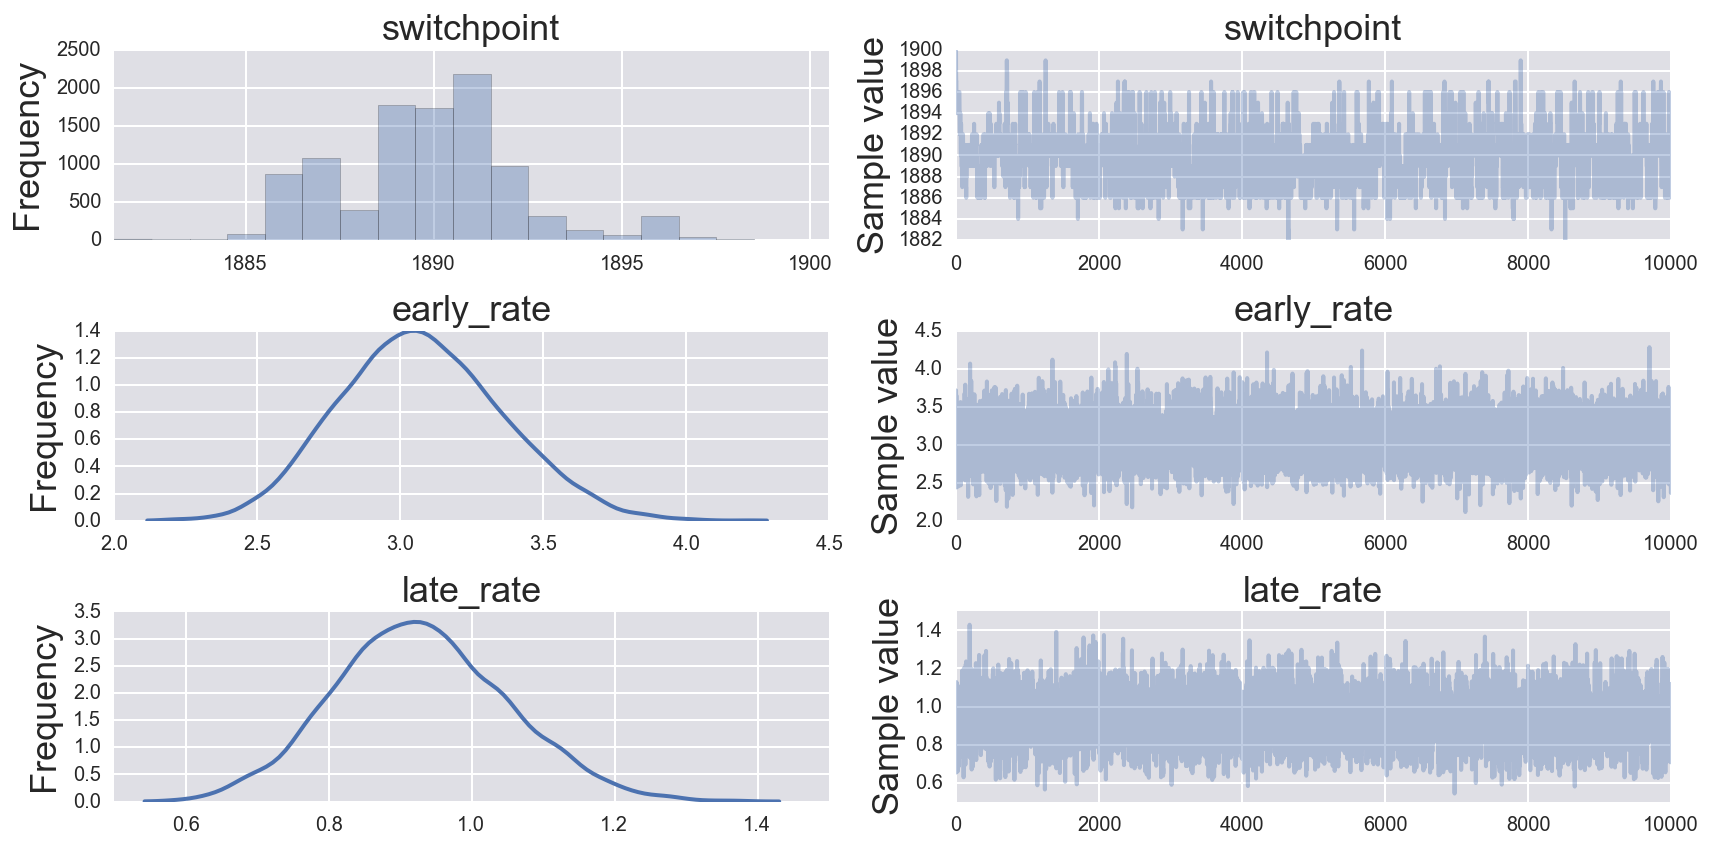

In [26]:
pymc3.traceplot(trace, ['switchpoint', 'early_rate', 'late_rate']);